# Imports

In [1]:
#import numpy as np
#import torch

# this file has everythng we need
from democnn3d import *

Using cpu


# Kalman Filter

In [99]:
def kalman(x, u, P, z):
    '''
    Kalman Filter
    x = pevious position [x,y,z]
    u = control input to go from previous to now
    P = previous covariance matrix
    z = sensor measurement from now
    '''
    # constants
    R =  np.array([[100**2, 0], [0, 70**2]]) # variance on noise for camera measurement
    Q = 12**2
    I = np.identity(3) #3x3 identity matrix
    H = np.array([[1, 0, 0], [0, 1, 0]])
    # Prediction
    xhat_p = x + u
    P_p = P + Q*I
    # Innovations
    inn=(z - H@xhat_p) #innovations
    S = H@P_p@(H.transpose()) + R #innovations covariance
    # Kalman Gain
    K = P_p@(H.transpose())@(np.linalg.inv(S))
    #reject measurements
    #Lam0 = 4.6052 #90% gate
    Lam0 = 3.2189 #80% gate
    #Lam0 = 2.4079 #70% gate
    #Lam0 = 1.8326 #60% gate
    #Lam0 = 1.3863 #50% gate
    #Lam0 = 1.0217 #40% gate
    #Lam0 = 0.7133 #30% gate
    #Lam0 = 0.4463 #20% gate
    #Lam0 = 0.2107 #10% gate    
    
    Lam=inn.transpose()@np.linalg.inv(S)@inn;
    if Lam>Lam0:
        # no update (use predictions)
        xhat_u = xhat_p
        P_u = P_p
        rej = 1
    else:  
        # Update
        xhat_u = xhat_p + K@inn
        P_u = (I-K@H) @ P_p @ ((I-K@H).transpose()) +K@R@(K.transpose())
        rej = 0
    return xhat_u, P_u, rej

In [3]:
# Sanity Check for KF (veriefied to match MATLAB)
x = np.array([[100], [100], [100]])
u = np.array([[10], [10], [10]])
P = np.array([[100**2,0,0],[0,100**2,0],[0,0,200**2]])
z = np.array([[105], [115]])

kalman(x, u, P, z)

(array([[108.19501779],
        [113.27796807],
        [110.        ]]),
 array([[ 6482.05209964,     0.        ,     0.        ],
        [    0.        ,  3493.65837265,     0.        ],
        [    0.        ,     0.        , 40144.        ]]),
 0)

# Sensor Model

In [4]:
# CNN
sensor_model = MnistNetwork()
sensor_model.load_state_dict(torch.load('cnn3d.pt',map_location=torch.device('cpu')))
sensor_model.eval()

MnistNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(11, 6), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(6, 4), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=36480, out_features=128, bias=True)
  (dense1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=128, out_features=2, bias=True)
)

# Collect/Organize Data

In [5]:
def overheadcam2arm(x, y):
    # converts location in overhead camera frame in pixels to locaiton of wrist in robot frame in mm
    pix2mm = 1.4 #[mm/pixel]
    #arm_origin = (309, 425) #arm origin in overhead camera frame [pixels]
    arm_origin = (309-1.708, 425+57.787) # with correction factors found heuristically
    #fiducial location in arm frame [pixels]
    fid_x = x-arm_origin[0]
    fid_y = arm_origin[1]-y
    fid_mag = np.sqrt(fid_x**2+fid_y**2) # magnitude of location vector
    #wrist loction in arm frame [pixels]
    theta = np.arctan2(fid_y, fid_x)
    wrist_x = (fid_mag-38/pix2mm)*np.cos(theta)
    wrist_y = (fid_mag-38/pix2mm)*np.sin(theta)
    return np.array([[wrist_x*pix2mm], [wrist_y*pix2mm]]) # wrist location in arm frame [mm]

def det_ind2ctr_ind(det_ind):
    # converts detection index to control index
    # required since images were sorted by the filenames instead of numerically
    indices = [str(t) for t in range(4015)]
    indices.sort()
    ctr_ind = int(indices[det_ind])-4 #first 4 images don't correspond to any control inputs for some reason
    if ctr_ind<0:
        return 0
    else:
        return ctr_ind

# test
# overheadcam2arm(185.677, 385.52) 
# det_ind2ctr_ind(0)

In [6]:
#load data

# first 64 points ate test data

detection_ind = np.load('detection_indices.npy') # Indices where there were detections
control_data = np.loadtxt('control_data.txt', delimiter=', ') # step, t, x, y, z
locs = np.load('locs.npy') # True locations from overhead cam
armpics = np.load('armpicscolor.npy')# Pictures from arm cam

In [8]:
#find control inputs
det_pos = np.zeros((len(detection_ind)+1, 3)) #detected positions
det_pos[0] = [0, 150, 150]

i = 1
for ind in detection_ind:
    c_ind = det_ind2ctr_ind(ind)
    det_pos[i] = [control_data[c_ind, 2], control_data[c_ind, 3], control_data[c_ind, 4]]
    i+=1

u = np.zeros((3, len(detection_ind))) # relative control inputs

for i in range(len(detection_ind)):
    u[0,[i]] = det_pos[i+1,0] - det_pos[i,0]
    u[1,[i]] = det_pos[i+1,1] - det_pos[i,1]
    u[2,[i]] = det_pos[i+1,2] - det_pos[i,2]
    
#create arrays for measurements and true positioins where columns are each timestep
z = np.zeros((2, len(detection_ind)))  #measurements
x_true = np.zeros((3, len(detection_ind))) #true positions
for i in range(len(detection_ind)):
    cam_bel = sensor_model(torch.Tensor(armpics[i])).cpu().detach().numpy() #camera belief of x-y location in camera frame [pixels]
    z[:,[i]] = overheadcam2arm(cam_bel[0,0], cam_bel[0,1])
    
    x_true[0:2,[i]] = overheadcam2arm(locs[i,0], locs[i,1])
    x_true[2,[i]] = 200

# Put it All Together Now

In [9]:
# check how well things line up for 1 index
i = 0
print(det_pos[i+1]) #command input
#print(locs[i])      #overhead location
print(x_true[:,i])  #overhead converted to arm frame
print(z[:,i])

[-143.  113.  200.]
[-140.46201116  112.50205922  200.        ]
[-65.65039051 267.5268792 ]


In [19]:
# estimate error in overhead to robot frame to tune origin defined in transormation funciton

num = len(detection_ind)
OH_error_x = np.zeros(num)
OH_error_y = np.zeros(num)

for i in range(num):
    OH_error_x[i] = det_pos[[i+1],0] - x_true[0,[i]]
    OH_error_y[i] = det_pos[[i+1],1] - x_true[1,[i]]

av_x = np.average(OH_error_x)
av_y = np.average(OH_error_y)

print('x correction (pixels): {}'.format(av_x/1.4))
print('y correction (pixels): {}'.format(av_y/1.4))

x correction (pixels): 0.7616861326950625
y correction (pixels): 0.10881095792304668


In [11]:
# error in CNN predictions

file1 = open('Test_error.txt', 'w')
file2 = open('Train_error.txt', 'w')

# test data
print('TEST DATA')
cam_error_x = np.zeros(64)
cam_error_y = np.zeros(64)

for i in range(64):
    cam_error_x[i] = z[0,[i]] - x_true[0,[i]]
    cam_error_y[i] = z[1,[i]] - x_true[1,[i]]
    file1.write("{}, {}\n".format(cam_error_x[i], cam_error_y[i]))

mag_error_x = np.average(np.absolute(cam_error_x)) # average magnitude of x error
sigma_x = np.std(cam_error_x)
mag_error_y = np.average(np.absolute(cam_error_y)) # average magnitude of y error
sigma_y = np.std(cam_error_y)
print('standard deviation of x error: {}'.format(sigma_x))
print('standard deviation of y error: {}'.format(sigma_y))

file1.close()


#test data
num = len(detection_ind)-64
print('\nTEST DATA')
cam_error_x = np.zeros(num)
cam_error_y = np.zeros(num)

for i in range(num):
    cam_error_x[i] = z[0,[i+64]] - x_true[0,[i+64]]
    cam_error_y[i] = z[1,[i+64]] - x_true[1,[i+64]]
    file2.write("{}, {}\n".format(cam_error_x[i], cam_error_y[i]))

sigma_x = np.std(cam_error_x)
sigma_y = np.std(cam_error_y)
print('standard deviation of x error: {}'.format(sigma_x))
print('standard deviation of y error: {}'.format(sigma_y))

file2.close()

TEST DATA
standard deviation of x error: 137.56079745407894
standard deviation of y error: 76.43298384270882

TEST DATA
standard deviation of x error: 33.2404517336925
standard deviation of y error: 24.323638333976184


# Filter Simulaiton

1
-16.929692435257582
19.16326677912734
19.027650117869076
14.741529455584605


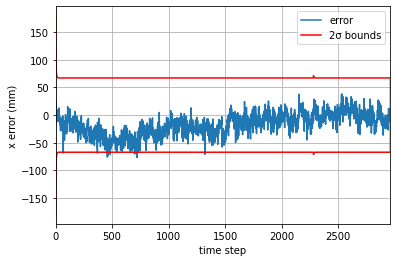

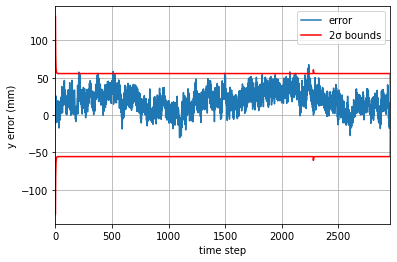

In [100]:
n_steps = 2963 #numer of timesteps to run the filter over
start_index = 64

# Initialize
x0 = np.array([[0], [150], [150]])
P0 = np.array([[200**2,0,0],[0,200**2,0],[0,0,200**2]])

x_est = np.zeros((3, n_steps))
x_est[:,[0]] = x0
P = np.zeros((3,3,n_steps))
P[:,:,0] = P0
rejections = 0

x_error = np.zeros((1, n_steps))
x_sigma = np.zeros((1, n_steps))
y_error = np.zeros((1, n_steps))
y_sigma = np.zeros((1, n_steps))


for i in np.arange(0,n_steps-1):
    ind = i+start_index
    
    (x_est[:,[i+1]], P[:,:,i+1], rej) = kalman(x_est[:,[i]], u[:,[ind]], P[:,:,i], z[:,[ind]])
    rejections += rej
    
    x_error[:,[i]] = x_est[0,[i+1]] - x_true[0,ind]#det_pos[ind+1,0]
    x_sigma[:,[i]] = np.sqrt(P[0,0,i+1])
    y_error[:,[i]] = x_est[1,[i+1]] - x_true[1,ind]#det_pos[ind+1,1]
    y_sigma[:,[i]] = np.sqrt(P[1,1,i+1])

# plot
t = np.arange(0,n_steps)

plt.figure(1)
plt.plot(t, x_error.transpose(),label='error')
plt.plot(t,2*x_sigma.transpose(),'r', label='2σ bounds')
plt.plot(t,-2*x_sigma.transpose(),'r')
#axs[0].set_xlim(0, 2)
plt.xlabel('time step')
plt.ylabel('x error (mm)')
plt.legend(loc='upper right')
plt.xlim(0,n_steps-2)
plt.grid()


plt.figure(2)
plt.plot(t, y_error.transpose(),label='error')
plt.plot(t,2*y_sigma.transpose(),'r', label='2σ bounds')
plt.plot(t,-2*y_sigma.transpose(),'r')
plt.legend(loc='upper right')
plt.xlabel('time step')
plt.ylabel('y error (mm)')
plt.xlim(0,n_steps-2)
plt.grid()



print(rejections)
print(np.average(x_error))
print(np.std(x_error))
print(np.average(y_error))
print(np.std(y_error))